# SPINN organize

In [ ]:
from setproctitle import setproctitle
setproctitle("PINN/SPINN")

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

import pyvista as pv
pv.start_xvfb()
pv.global_theme.trame.server_proxy_enabled = True
pv.set_jupyter_backend('static')

## Generation of bottom boundary data

### Low Lou

Saved /userhome/jeon_mg/workspace/_data/lowlou_128_128_128/b.vtk
Saved /userhome/jeon_mg/workspace/_data/lowlou_128_128_128/b_bottom.npy


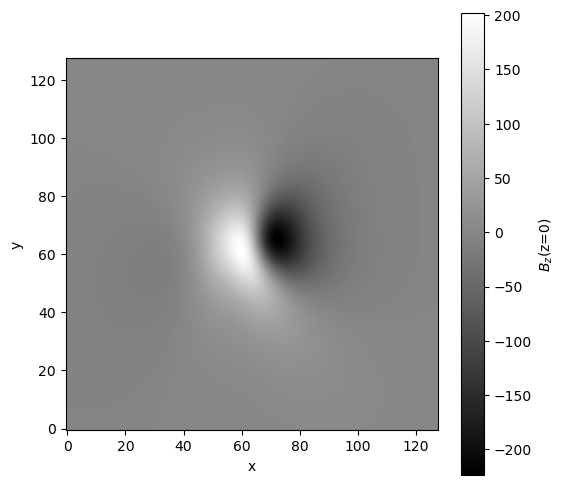

In [ ]:
import numpy as np
from cmspinn.prepare_lowlou import PrepareLowLou

base_path = os.path.expanduser('~/workspace/_data')

creater = PrepareLowLou(base_path=base_path,
                        bounds=[-1, 1, -1, 1, 0, 2], Nx=128, Ny=128, Nz=128, 
                        n=1, m=1, l=0.3, Phi=np.pi/3, 
                        abs=True)

creater.cal_and_save_lowlou()
creater.plot_and_save_lowlou_bottom()

### HMI

In [ ]:
from cmspinn.prepare_hmi import PrepareHMI

base_path = os.path.expanduser('~/workspace/_data/NOAA12673/b_bottom/')
hmi_path = '/nas/obsdata/sdo_AR/NOAA12673_HARP7115/hmi/'

creater = PrepareHMI(base_path, hmi_path)

creater.load_hmi_data()
creater.save_bottom()

/userhome/jeon_mg/mambaforge/envs/pinf/lib/python3.10/site-packages/sunpy/map/mapbase.py:732: SunpyMetadataWarning: Could not parse unit string "Mx/cm^2" as a valid FITS unit.
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards.
  warn_metadata(f'Could not parse unit string "{unit_str}" as a valid FITS unit.\n'


Saved /userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_000000.npy
Saved /userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_001200.npy
Saved /userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_002400.npy
Saved /userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_003600.npy
Saved /userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_004800.npy
Saved /userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_010000.npy
Saved /userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_011200.npy
Saved /userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_012400.npy
Saved /userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_013600.npy
Saved /userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_014800.npy
Saved /userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_020000.npy
Saved /userhome/jeon_mg/workspac

## NLFFF extrapolation

### PINN

#### Low Lou

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from cmspinn.pinn_nf2_old import NF2Trainer

Nz = 128
spatial_norm = 32
b_norm = 100
b_bottom_path = os.path.expanduser('~/workspace/_data/lowlou_128_128_128/b_bottom.npy')

num_neurons = 256
w_ff = 1
w_div = 1
decay_iterations = 25000

output_path = os.path.join(Path(b_bottom_path).parent, 'PINN')

with open(b_bottom_path, 'rb') as f:
    b_bottom = np.load(f)

#--------------------------------

trainer = NF2Trainer(output_path, b_bottom, Nz, spatial_norm, b_norm,
                     meta_path=None, dim=num_neurons, w_div=w_div, w_ff=w_ff,
                     decay_iterations=decay_iterations)

#--------------------------------

total_iterations = 5000
log_interval = 1000
batch_size = 10000
num_worker = 2

start = time.time()

trainer.train(total_iterations, batch_size, log_interval, log_interval, num_workers=num_worker)

runtime = time.time() - start
trainer.logger.info(f'Runtime --> total: {runtime:.2f}sec ({(runtime/(total_iterations-1)*1000):.2f}ms/iter.)')

with open(os.path.join(output_path, 'losses.npy'), "rb") as f:
    losses = np.load(f)

plt.close()
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(losses)
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
plt.show()

Configuration:
dim: 256, w_div: 1.000000, w_ff: 1.000000, decay_iterations: 25000, potential: True, vector_potential: False, 
Using device: cuda (gpus 1) ['NVIDIA RTX A6000']
Potential Boundary: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]
Resuming training from iteration 5000
Runtime --> total: 0.00sec (0.00ms/iter.)


Training already finished!


100%|██████████| 210/210 [00:00<00:00, 540.30it/s]


Saved /userhome/jeon_mg/workspace/_data/lowlou_128_128_128/PINN/vtk/B_pinn_final.vtk


In [ ]:
from cmspinn.pinn_nf2_viz import pinn_cube
save_path = os.path.join(output_path, 'model_final.pt')
pinn = pinn_cube(save_path)
pinn.calculate_magnetic_fields(batch_size=batch_size)
vtk_path = os.path.join(output_path, 'vtk')
os.makedirs(vtk_path, exist_ok=True)
B_pinn_vtk_path = os.path.join(vtk_path, 'B_pinn_final.vtk')
pinn.grid.save(B_pinn_vtk_path)
print(f'Saved {B_pinn_vtk_path}')

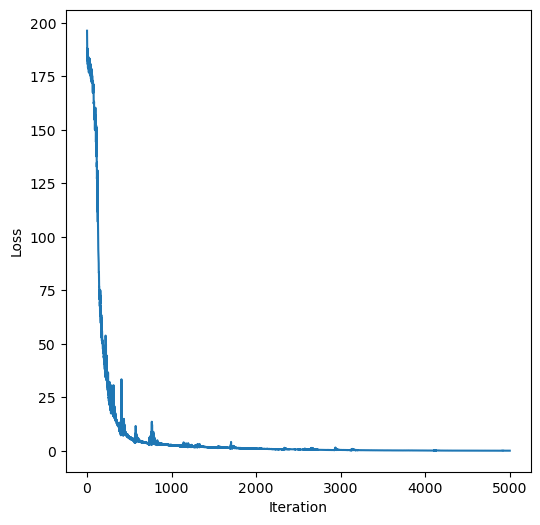

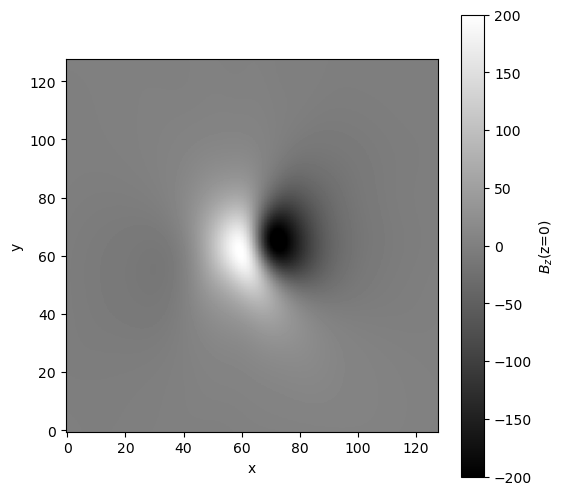

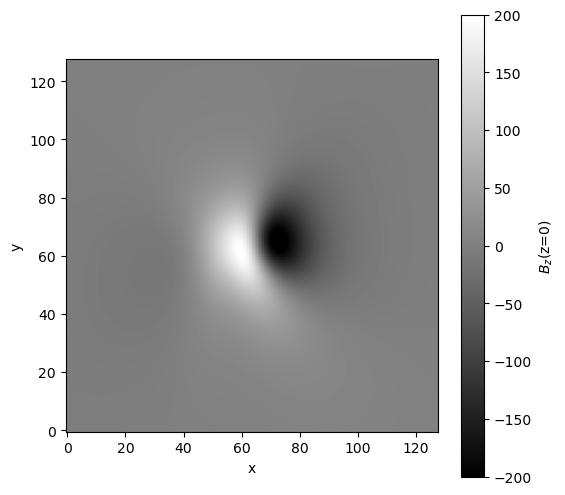

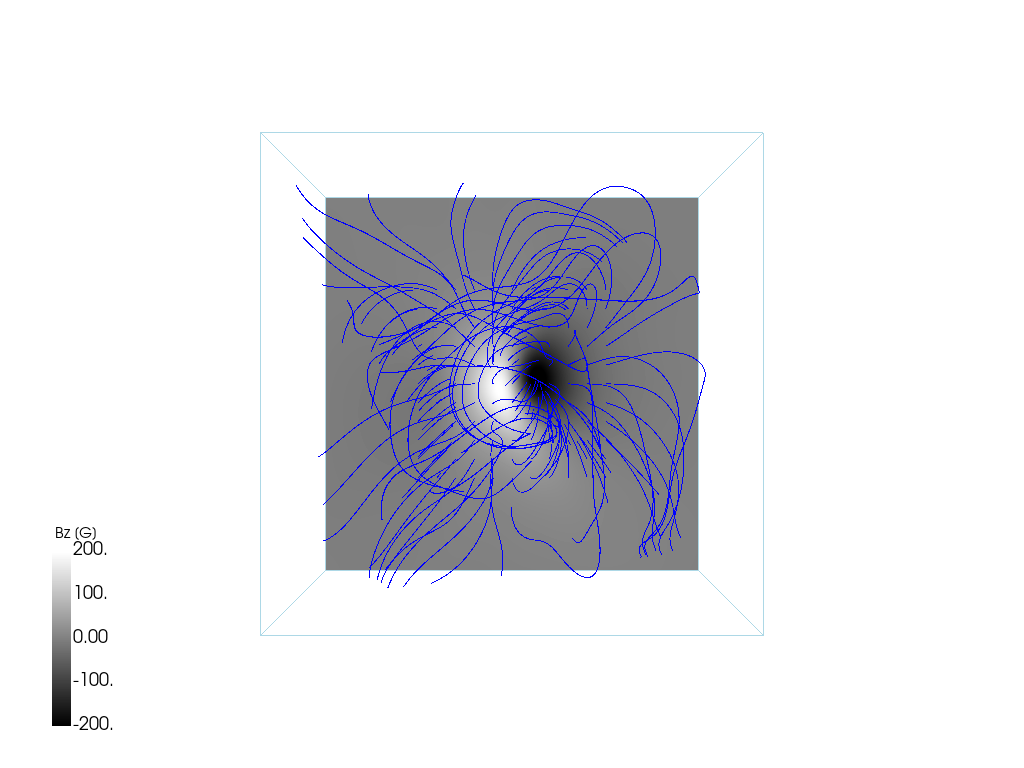

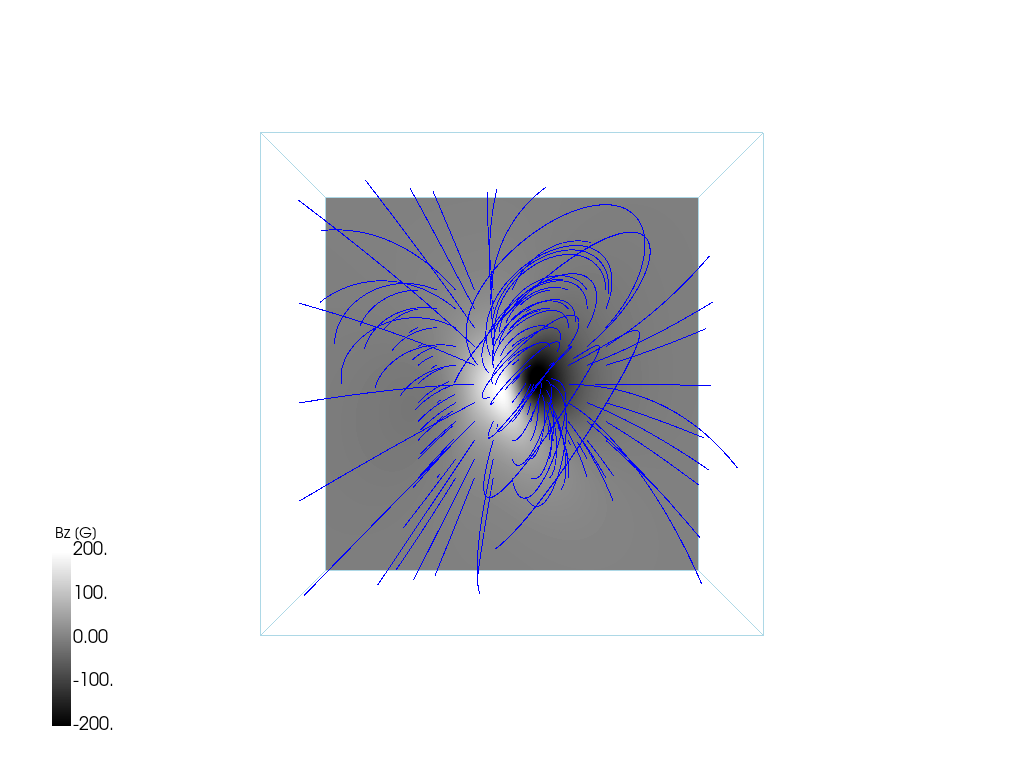

<pyvista.plotting.plotter.Plotter>

In [ ]:
from cmspinn.mag_viz import mag_plotter





b_vtk_path = os.path.join(Path(b_bottom_path).parent, 'b.vtk')
b_mesh = pv.read(b_vtk_path)
b_ll = mag_plotter(b_mesh)

B_pinn_mesh = pv.read(B_pinn_vtk_path)
B_pinn = mag_plotter(B_pinn_mesh)

vmin = -200
vmax = 200

B_pinn.plt_Bz_imshow(z=0, vmin=vmin, vmax=vmax)
b_ll.plt_Bz_imshow(z=0, vmin=vmin, vmax=vmax)

i_siz = 64
j_siz = 64

i_res = 10
j_res = 10

B_pinn.pv_streamline_Bz(camera_position='xy', i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax)
b_ll.pv_streamline_Bz(camera_position='xy', i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax)

#### HMI

### SPINN